In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path = 's3://velocity-u.zarr/'
remote_files = fsg.glob(data_path)

store = s3fs.S3Map(root=data_path, s3=fsg, check=False)
du = xr.open_zarr(store=store, consolidated=True)
du = du.rename({'depthu' : 'depth'})
du 

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depth: 75, time_counter: 73, x: 1580, y: 1801)
Coordinates:
  * depth                 (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat               (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    time_centered         (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter          (time_counter) object 2000-01-03 12:00:00 ... 2000-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (time_counter, depth, axis_nbounds) float32 dask.array<chunksize=(1, 75, 2), meta=np.ndarray>
    sozotaux              (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(73, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(73, 2), meta=np.ndarray>
    utau_atmoce           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    utau_iceoce           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    uwspd10               (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    vozocrtx              (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
Attributes:
    CASE:              REF08
    CONFIG:            CREG12.L75
    Conventions:       CF-1.5
    description:       ocean U grid variables
    name:              /scratch/cnt0028/lpo7420/talandic/CREG12.L75-REF08-XIO...
    output_frequency:  5d
    production:        An IPSL model
    start_date:        19790101
    timeStamp:         2020-May-14 08:39:48 CEST
    title:             ocean U grid variables

In [5]:
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

In [6]:
x_p = 500
y_p = 500
d = mbathy.isel(x=x_p, y=y_p).values

'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'
indexer = [int(i) for i in np.linspace(1,d-2,5)]
indexer

[1, 15, 30, 44, 59]

In [7]:
dyp = u.isel(x=x_p, y=y_p, depth = indexer)
dyp.depth.values

array([1.5558553e+00, 3.5740204e+01, 1.9978996e+02, 8.5667896e+02,
       2.9555703e+03], dtype=float32)

In [8]:
dyp = u.isel(x=x_p, y=y_p, depth = indexer)

cov_p = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
values, vectors = np.linalg.eig(cov_p)
order = values.argsort()[::-1]
values, vectors = values[order], vectors[order, :] #før: vectors[:, order] --> endret: vectors[order, :]

print(cov_p.shape) 
print(cov_p)
print('------------------------------------------------------')    
print(values[0]) 
print('------------------------------------------------------')    
print(values[1])
print('------------------------------------------------------')    
print(vectors[0]) 

(5, 5)
[[ 1.21651118e-04  2.17096366e-07 -4.12910125e-06  3.15405035e-07
   1.44159419e-06]
 [ 2.17096366e-07  1.49125131e-05  6.04142352e-06  1.19776644e-06
   8.12288153e-07]
 [-4.12910125e-06  6.04142352e-06  5.88747792e-06  8.47318303e-07
   2.05941561e-07]
 [ 3.15405035e-07  1.19776644e-06  8.47318303e-07  8.42582059e-07
   7.09699101e-07]
 [ 1.44159419e-06  8.12288153e-07  2.05941561e-07  7.09699101e-07
   8.17511080e-07]]
------------------------------------------------------
0.00012181590277513072
------------------------------------------------------
1.8084229244801102e-05
------------------------------------------------------
[ 0.99929468  0.0148112  -0.0317164  -0.01328011 -0.00291124]


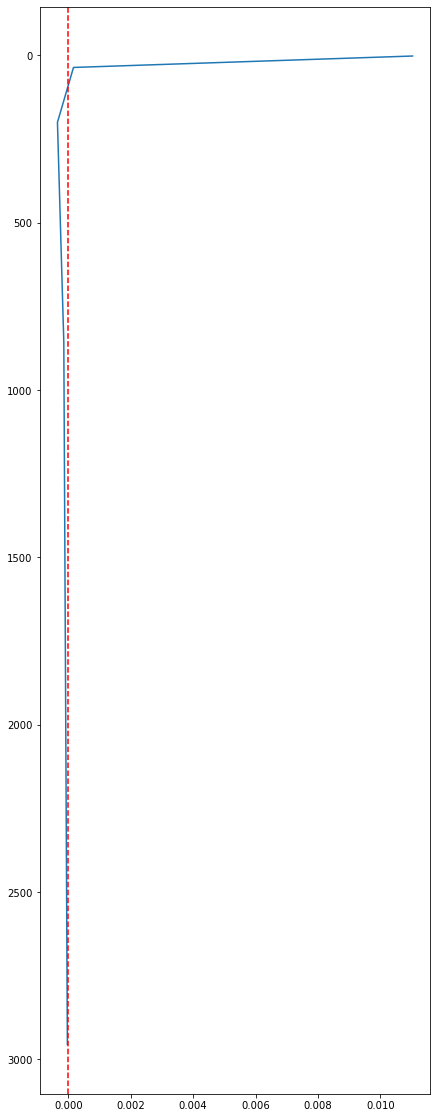

In [9]:
'figure ikke transponert'
fig, ax = plt.subplots(1,1,figsize = (7,20))

ax.plot(vectors[0]*np.sqrt(values[0]), dyp.depth)
ax.axvline(0, color='r', linestyle = '--')
ax.invert_yaxis()

In [10]:
'''figure ikke transponert'
fig, ax = plt.subplots(1,1,figsize = (7,20))

ax.plot(vectors.T[0]*np.sqrt(values[0]), dyp.depth)
ax.axvline(0, color='r', linestyle = '--')
ax.invert_yaxis()'''

"figure ikke transponert'\nfig, ax = plt.subplots(1,1,figsize = (7,20))\n\nax.plot(vectors.T[0]*np.sqrt(values[0]), dyp.depth)\nax.axvline(0, color='r', linestyle = '--')\nax.invert_yaxis()"

In [11]:
x_p2 = 660
y_p2 = 790 

'Finding the level the given location dosent have values for anymore'

mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))
d2 = mbathy.isel(x=x_p2, y=y_p2).values

'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'
indexer = [int(i) for i in np.linspace(1,d2-2,5)]

dyp2 = u.isel(x=x_p2, y=y_p2, depth = indexer) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
print(dyp2.shape)

cov_p2 = np.cov(dyp2.T, bias=True) # uten .T ble den en 73x73 matrise 
values2, vectors2 = np.linalg.eig(cov_p2)
order2 = values2.argsort()[::-1]
values2, vectors2 = values2[order2], vectors2[order2, :]

print(cov_p2.shape) 
print(cov_p2)
print('------------------------------------------------------')    
print(values2[0]) 
print('------------------------------------------------------')    
print(values2[1])
print('------------------------------------------------------')    
print(vectors2[0])    

(73, 5)
(5, 5)
[[0.00092427 0.00085472 0.00068162 0.00058716 0.00062232]
 [0.00085472 0.00079677 0.00064118 0.00054954 0.0005784 ]
 [0.00068162 0.00064118 0.00054418 0.00046407 0.00047913]
 [0.00058716 0.00054954 0.00046407 0.00043941 0.00045934]
 [0.00062232 0.0005784  0.00047913 0.00045934 0.00053878]]
------------------------------------------------------
0.003084941351930053
------------------------------------------------------
0.00010923982848343401
------------------------------------------------------
[-0.54042421  0.38635988  0.40240816 -0.5855382  -0.23212151]


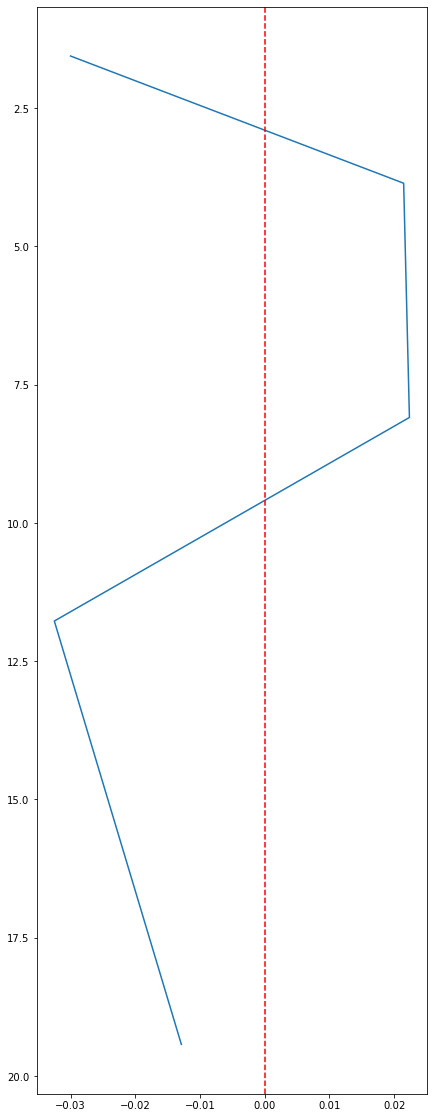

In [12]:
'figure ikke transponert'
fig, ax = plt.subplots(1,1,figsize = (7,20))

ax.plot(vectors2[0]*np.sqrt(values2[0]),dyp2.depth)
ax.axvline(0, color='r', linestyle = '--')
ax.invert_yaxis()

# punkt 3

In [13]:
x_p3 = 650
y_p3 = 300 

'Finding the level the given location dosent have values for anymore'

d3 = mbathy.isel(x=x_p3, y=y_p3).values

'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'
indexer = [int(i) for i in np.linspace(1,d3-2,5)]

dyp3 = u.isel(x=x_p3, y=y_p3, depth = indexer) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
print(dyp3.shape)

cov_p3 = np.cov(dyp3.T, bias=True) # uten .T ble den en 73x73 matrise 
values3, vectors3 = np.linalg.eig(cov_p3)
order3 = values3.argsort()[::-1]
values3, vectors3 = values3[order3], vectors3[order3, :]

print(cov_p3.shape) 
print(cov_p3)
print('------------------------------------------------------')    
print(values3[0]) 
print('------------------------------------------------------')    
print(values3[1])
print('------------------------------------------------------')    
print(vectors3[0])    

(73, 5)
(5, 5)
[[ 1.43188285e-04  4.88758090e-06 -1.88702489e-06 -1.54596782e-06
  -1.71688204e-07]
 [ 4.88758090e-06  8.02106778e-06  8.22199151e-08  1.85832821e-08
  -1.04016832e-07]
 [-1.88702489e-06  8.22199151e-08  8.67081314e-07  4.16215937e-07
   6.27244563e-08]
 [-1.54596782e-06  1.85832821e-08  4.16215937e-07  7.96740967e-07
   1.76539763e-07]
 [-1.71688204e-07 -1.04016832e-07  6.27244563e-08  1.76539763e-07
   5.51422404e-07]]
------------------------------------------------------
0.0001434067220690015
------------------------------------------------------
7.849981537247678e-06
------------------------------------------------------
[-9.99201914e-01 -3.56564784e-02 -1.75897092e-02  3.83255743e-03
 -2.52058429e-04]


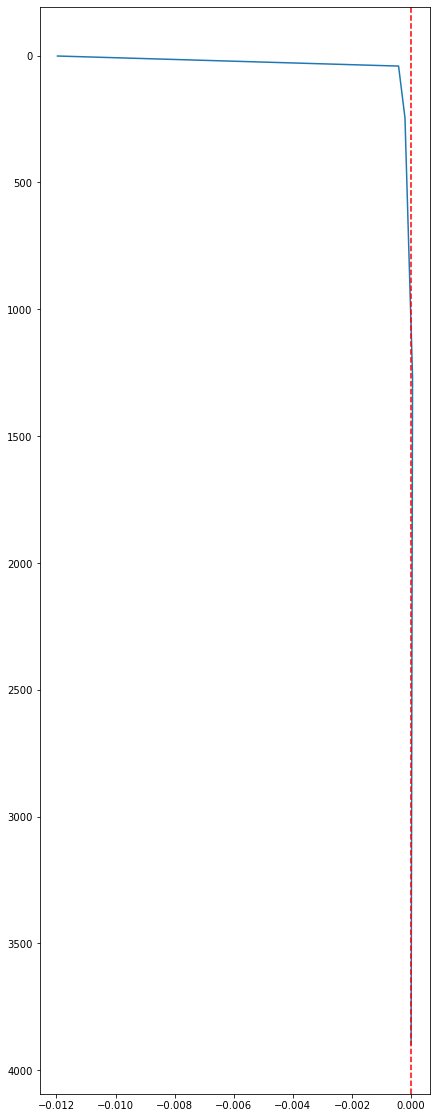

In [14]:
'figure ikke transponert'
fig, ax = plt.subplots(1,1,figsize = (7,20))

ax.plot(vectors3[0]*np.sqrt(values3[0]),dyp3.depth)
ax.axvline(0, color='r', linestyle = '--')
ax.invert_yaxis()

## Punkt 4

In [15]:
x_p4 = 870
y_p4 = 600 

'Finding the level the given location dosent have values for anymore'

d4 = mbathy.isel(x=x_p4, y=y_p4).values

'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'
indexer = [int(i) for i in np.linspace(1,d4-2,5)]

dyp4 = u.isel(x=x_p4, y=y_p4, depth = indexer) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter

cov_p4 = np.cov(dyp4.T, bias=True) # uten .T ble den en 73x73 matrise 
values4, vectors4 = np.linalg.eig(cov_p4)
order4 = values4.argsort()[::-1]
values4, vectors4 = values4[order4], vectors4[order4, :]

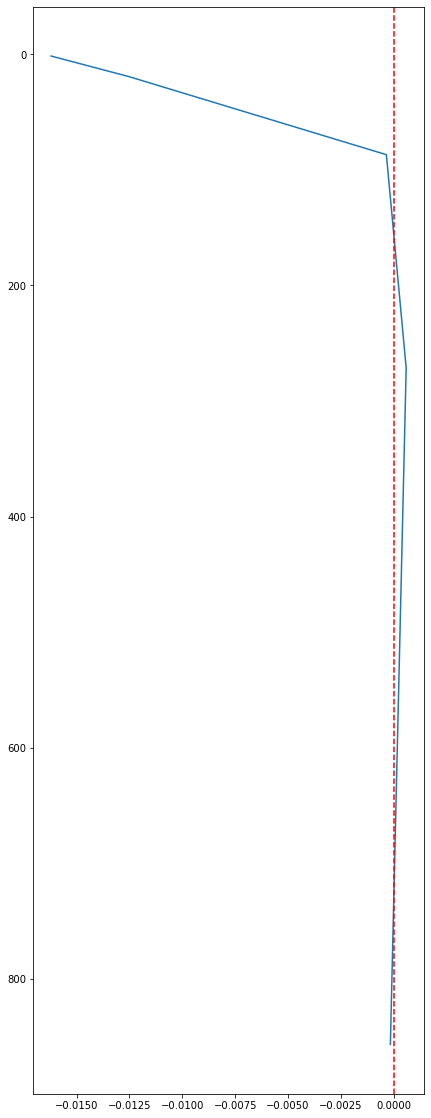

In [16]:
'figure ikke transponert'
fig, ax = plt.subplots(1,1,figsize = (7,20))

ax.plot(vectors4[0]*np.sqrt(values4[0]),dyp4.depth)
ax.axvline(0, color='r', linestyle = '--')
ax.invert_yaxis()

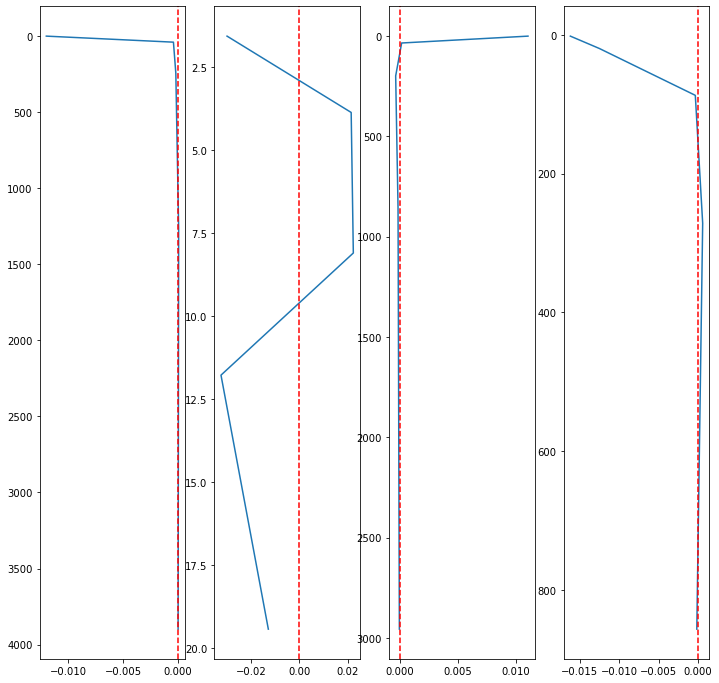

In [17]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1,4,figsize = (12,12))

ax1.plot(vectors3[0]*np.sqrt(values3[0]),dyp3.depth)
ax1.axvline(0, color='r', linestyle = '--')
ax1.invert_yaxis()

ax2.plot(vectors2[0]*np.sqrt(values2[0]),dyp2.depth)
ax2.axvline(0, color='r', linestyle = '--')
ax2.invert_yaxis()

ax3.plot(vectors[0]*np.sqrt(values[0]),dyp.depth)
ax3.axvline(0, color='r', linestyle = '--')
ax3.invert_yaxis()

ax4.plot(vectors4[0]*np.sqrt(values4[0]),dyp4.depth)
ax4.axvline(0, color='r', linestyle = '--')
ax4.invert_yaxis()

 BC modes with acctual stratification have zerocrossings higher in the water column with large ampiltude near surface. The BC modes differ in the upper 10m, where the modes tends to flatten out, indicating weak stratification, thus the shear in the mixed layer is more BT than BC
 
 --> fra joes copendium

# Trying loop 

In [69]:
'does this make the loop go faster?'
lenx = np.arange(0,1200)
leny = np.arange(0,900)

val = np.full((1200,900), np.nan)
vec = np.full((1200,900,5), np.nan)
dybde = np.full((1200,900), np.nan)

'Looping over the area, x,y '
for x in lenx:
    for y in leny:
        d = mbathy.isel(x=x,y=y).values # henter nivået for bunn i punktet
        print(d)
        if d<= 8:
            continue
        else:
            'Making a U-matrix with all 73 timestep as variables and all depths as samples'
            'Lager indexer for å lage covmatrise for, henter fra topp, dyp og i mellom'
            indexer = [int(i) for i in np.linspace(1,d-2,5)]# -2 pga d=0, vil over bunnnivå
            dyp = u.isel(x=x, y=y, depth = indexer) 
            print(dyp.shape)
            cov_d = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise, ønsker dxd
            print(cov_d.shape)
            values, vectors = np.linalg.eig(cov_d)
            order = values.argsort()[::-1]
            values, vectors = values[order], vectors[:, order]
            vec[x,y,:5] = vectors[0]
            val[x,y] = values[0]
            dybde[x,y] = d-2
        print('y=', y, ' ferdig')
        print('x=', x, ' ferdig')

vec = xr.DataArray(vec)
val = xr.DataArray(val)
dybde = xr.DataArray(dybde)

PCz = xr.merge([vec.to_dataset(name='vectors'),
                val.to_dataset(name='values'),
                dybde.to_dataset(name='depth')],
                compat='override')

#PCz.to_netcdf(path = filedir + 'PCz.nc')
#PCz.to_zarr('/uio/lagringshotell/geofag/students/metos/kaervik/Master/PCz_5p.zarr', consolidated=True)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
5
5
6
7
7
7
6
6
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
4
4
6
6
10
(73, 5)
(5, 5)
y= 182  ferdig
x= 0  ferdig
11
(73, 5)
(5, 5)
y= 183  ferdig
x= 0  ferdig
11
(73, 5)
(5, 5)
y= 184  ferdig
x= 0  ferdig
12
(73, 5)
(5, 5)
y= 185  ferdig
x= 0  ferdig
12
(73, 5)
(5, 5)
y= 186  ferdig
x= 0  ferdig
12
(73, 5)
(5, 5)
y= 187  ferdig
x= 0  ferdig
12
(73, 5)
(5, 5)
y= 188  ferdig
x= 0  ferdig
12
(73, 5)
(5, 5)
y= 189  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 190  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 191  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 192  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 193  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 194  ferdig
x= 0  ferdig
13
(73, 5)
(5, 5)
y= 195  ferdig
x= 0 

KeyboardInterrupt: 